In [4]:
import numpy as np
import corner
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
plt.rcParams['font.family'] = 'DejaVu Sans'
rc('text', usetex=True)
plt.rcParams.update({'font.size': 19})
import ptemcee
import h5py
import inspect
import pandas as pd
import json
import qnm
import random
from scipy.optimize import minimize
#import hope

### <font text color = 'Goldenrod'>Import data and setup</font>

In [5]:
#rootpath: root path to nr data
#npoints: number of points you re using for your sampling
#nmax: tone index --> nmax = 0 if fitting the fundamental tone
#tshift: time shift after the strain peak

burnin = 20
nmax=0
tshift=0

nwalkers = 8
ntemps=10
#Why can't I change the number of temperatures here?
ndim = int(4*(nmax+1))
npoints=1000

rootpath="/Users/xisco"
project_path=rootpath+"/git/rdstackingproject"
chain_file = project_path+'/plotsmc/Test'+'nmax='+str(nmax)+'_tshift='+str(tshift)+'_'+str(npoints)+'pt_chain.png'
chain_file_dat=project_path+'/plotsmc/Test'+'nmax='+str(nmax)+'_tshift='+str(tshift)+'_'+str(npoints)+'pt_chain.csv'
corner_file = project_path+'/plotsmc/Test'+'nmax='+str(nmax)+'_tshift='+str(tshift)+'_'+str(npoints)+'pt_corner.pdf'

### <font text color = 'Goldenrod'> Necessary functions </font> 

In [6]:
#TimeOfMaximum
def FindTmaximum(y):
    #Determines the maximum absolute value of the complex waveform
    absval = y[:,1]*y[:,1]+y[:,2]*y[:,2]
    vmax=np.max(absval)
    index = np.argmax(absval == vmax)
    timemax=gw_sxs_bbh_0305[index,0]
    return timemax

# You do not need that. This is a fit to the energy radiated = 1 - final_mass
def EradUIB2017(eta,chi1,chi2):
    
    m1=0.5*(1+(1-4*eta)**0.5)
    m2=0.5*(1-(1-4*eta)**0.5)
    S= (m1**2*chi1 + m2**2*chi2)/(m1*m1 + m2*m2)
    
    erad=(((1-(2*(2)**0.5)/3)*eta+0.5609904135313374*eta**2-0.84667563764404*eta**3+3.145145224278187*eta**4)*(1+S**3 *(-0.6320191645391563+ 4.952698546796005*eta-10.023747993978121*eta**2)+S**2*(-0.17762802148331427+ 2.176667900182948*eta**2)+S*(-0.13084389181783257- 1.1387311580238488*eta+5.49074464410971*eta**2)))/(1+S*(-0.9919475346968611+ 0.367620218664352*eta+4.274567337924067*eta**2))-0.01978238971523653*S*(1-4.91667749015812*eta)*(1-4*eta)**0.5 *eta *(chi1-chi2)-0.09803730445895877*(1-4*eta)**0.5*(1-3.2283713377939134*eta)*eta**2 *(chi1-chi2)+0.01118530335431078*eta**3 *(chi1-chi2)**2
    return  erad

In [9]:
#This loads the 22 mode data
gw = {}
gw["SXS:BBH:0305"] = h5py.File(project_path+"/SXS/BBH_SKS_d14.3_q1.22_sA_0_0_0.330_sB_0_0_-0.440/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5", 'r')
gw_sxs_bbh_0305 = gw["SXS:BBH:0305"]["Extrapolated_N2.dir"]["Y_l2_m2.dat"]

# Remember to download metadata.json from the simulation with number: 0305. Download Lev6/metadata.json
# This postprocesses the metadata file to find the final mass and final spin
metadata = {}
with open(project_path+"/SXS/BBH_SKS_d14.3_q1.22_sA_0_0_0.330_sB_0_0_-0.440/Lev6/metadata.json") as file:
    metadata["SXS:BBH:0305"] = json.load(file)

af = metadata["SXS:BBH:0305"]['remnant_dimensionless_spin'][-1]
mf = metadata["SXS:BBH:0305"]['remnant_mass']

In [11]:
#times --> x axis of your data
times = gw_sxs_bbh_0305[:,0]
tmax=FindTmaximum(gw_sxs_bbh_0305)
t0=tmax +tshift

#Select the data from t0 onwards
position = np.argmax(times >= (t0))
gw_sxs_bbh_0305rd=gw_sxs_bbh_0305[position:-1]
timesrd=gw_sxs_bbh_0305[position:-1][:,0]

# Depending on nmax, you load nmax number of freqs. and damping times from the qnm package
omegas = []
for i in range (0,nmax+1):
    grav_220 = qnm.modes_cache(s=-2,l=2,m=2,n=i)
    omega = grav_220(a=af)[0]
    omegas.append(omega)

In [12]:
data = gw_sxs_bbh_0305rd[:,1] - 1j*gw_sxs_bbh_0305rd[:,2]
norm2=np.sum(data*np.conj(data))

### <font text color = 'Goldenrod'>Fitting</font>

In [13]:
#Functions

#RD model for nmax tones. Amplitudes are in (xn*Exp[i yn]) version. Used here.
def model_dv_af(theta):
    #x0, y0= theta
    #Your nmax might not align with the dim of theta. Better check it here.
    assert int(len(theta)/4) == nmax + 1, 'Please recheck your n and parameters'
    w = (np.real(omegas))/mf
    tau=-1/(np.imag(omegas))*mf
    dim =int(len(theta)/4)        
    
    xvars = [theta[4*i] for i in range (0, dim)]
    yvars = [theta[4*i+1] for i in range (0, dim)]
    avars = [theta[4*i+2] for i in range (0, dim)]
    bvars = [theta[4*i+3] for i in range (0, dim)]        

    ansatz = 0
    for i in range (0,dim):
       # bvars[0]=0
       # avars[0]=0
       # bvars[1]=0
       # avars[1]=0
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-(timesrd-timesrd[0])/(tau[i]*(1+bvars[i])))\
        *(np.cos((1+avars[i])*w[i]*timesrd)-1j*np.sin((1+avars[i])*w[i]*timesrd))
    # -1j to agree with SXS convention
    return ansatz


# LogLikelihood function. It is just a Gaussian loglikelihood based on computing the residuals^2
def log_likelihood(theta):
    #modelev = model_dv(theta)
    modelev = model_dv_af(theta)
    
    #return  -np.sum(modelev - gw_sxs_bbh_0305rd[:,2] )**2)
    return  -np.sum((gw_sxs_bbh_0305rd[:,1] - modelev.real)**2+(gw_sxs_bbh_0305rd[:,2] - modelev.imag)**2)


# LogLikelihood match function. Not used at the moment. It is just a Gaussian match loglikelihood based on computing the match
'''def log_likelihood_match(theta):
    
    #model and data
    modelev = model_dv_af(theta)
    data = gw_sxs_bbh_0305rd[:,1] - 1j*gw_sxs_bbh_0305rd[:,2]
    
    #norms
    norm1=np.sum(modelev*np.conj(modelev))
    norm2=np.sum(data*np.conj(data))

    #mismatch
    myTable = data*np.conj(modelev);    
    return -(1-(np.sum(myTable)).real/np.sqrt(norm1*norm2)).real'''

def log_likelihood_match(theta):
    
    #model and data
    modelev = model_dv_af(theta)
    
    #norms
    norm1=np.sum(modelev*np.conj(modelev))
    
    #mismatch
    myTable = data*np.conj(modelev);    
    return -(1-(np.sum(myTable)).real/np.sqrt(norm1*norm2)).real

# Logposterior distribution for the residuals case.
# The evidence is just a normalization factor
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)


# Logposterior distribution for the mismatch case. Not used yet.
'''def log_probability_match(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_match(theta)'''

def log_probability_match(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_match(theta)


# Logprior distribution. It defines the allowed range my variables can vary over. 
#It works for the (xn*Exp[iyn]) version!!! 
def log_prior(theta):
    x_s = theta[0::4]
    y_s = theta[1::4]
    a_s = theta[2::4]
    b_s = theta[3::4]
    if all(0 <= t <= 10 for t in x_s) and all(-2*np.pi <= t <= 2*np.pi for t in y_s) and all(-1 <= t <= 1 for t in a_s) and all(-1 <= t <= 5 for t in b_s):
        return 0.0
    return -np.inf

In [14]:
ndim = int(4*(nmax+1))

#Does the difference in pos and pos_aux matter? Why the range is different here?
pos = [random.uniform(0.,10) ,random.uniform(-np.pi,np.pi) ,random.uniform(-1,1) ,random.uniform(-0.99,1)]
for i in range (1,nmax+1):
    pos_aux = [random.uniform(1,8) ,random.uniform(0.01,0.9*2*np.pi) ,random.uniform(-.1,.1) ,random.uniform(-.1,.1)]
    pos = pos + pos_aux

pos = pos + 1e-4 * np.random.randn(ntemps,nwalkers,ndim)
sampler = ptemcee.Sampler(nwalkers, ndim,log_likelihood,log_prior, ntemps=ntemps)
sampler.run_mcmc(pos,npoints);

In [15]:
paramlabels = []
for i in range (nmax+1):
    sublabel = [r'$x_' + str(i) + '$', r'$y_' + str(i) + '$', r'$\alpha_' + str(i) + '$',r'$\beta_' + str(i) + '$']
    paramlabels += sublabel

<Figure size 432x288 with 0 Axes>

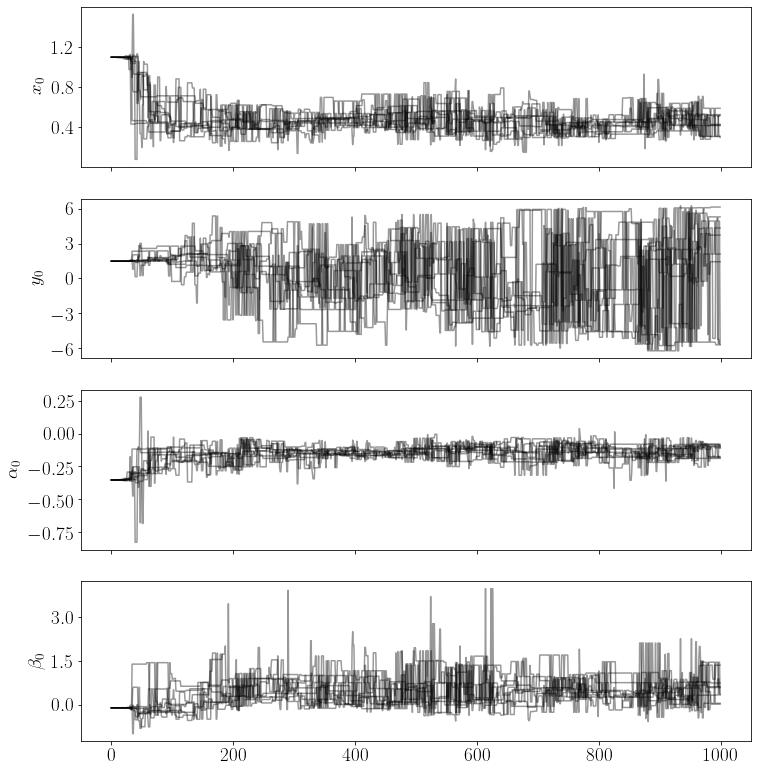

In [16]:
plt.clf()
fig, axes = plt.subplots(4*(nmax+1), 1, sharex=True, figsize=(12, 13.5*(nmax+1)))
for i in range(4*(nmax+1)):
    axes[i].plot(sampler.chain[0,:, :, i].T, color="k", alpha=0.4)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    axes[i].set_ylabel(paramlabels[i])
fig.savefig(rootpath+'/git/rdstackingproject/plotsmc/Test'+'nmax='+str(nmax)+'_tshift='+str(tshift)+'_'+str(npoints)+'pt_chain.png', format = 'png', dpi = 384, bbox_inches = 'tight')
#plt.show()

[ 0.45481092  1.04363779 -0.14207823  0.39283084]


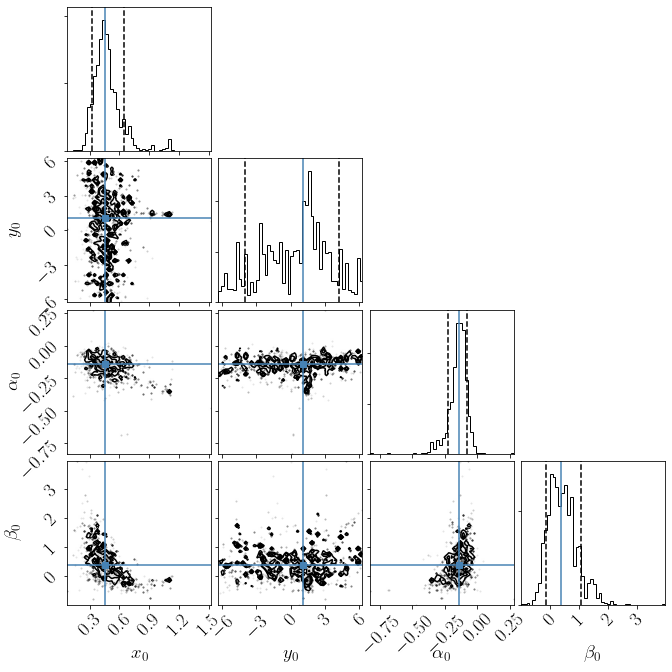

In [17]:
samples = sampler.chain[0,:, burnin:, :].reshape((-1, ndim))
median=np.median(samples, axis=0)
print(median)
figcorn = corner.corner(samples, bins = 50, labels=paramlabels,truths=median,quantiles=(0.1, 0.9))
figcorn.savefig(rootpath+'/git/rdstackingproject/plotsmc/Test'+'nmax='+str(nmax)+'_tshift='+str(tshift)+'_'+str(npoints)+'pt_corner.pdf', format = 'pdf')

In [ ]:
fig.savefig(chain_file, format = 'png', dpi = 384, bbox_inches = 'tight')
out = np.concatenate(sampler.chain[0,:])
np.savetxt(chain_file_dat,out, fmt='%d')

samples = sampler.chain[0,:, burnin:, :].reshape((-1, ndim))
median=np.median(samples, axis=0)

figcorn = corner.corner(samples, bins = 50, labels=paramlabels,truths=median,quantiles=(0.1, 0.9))
figcorn.savefig(corner_file, format = 'pdf')

In [133]:
#prob = sampler.logprobability[0,0]
#temp = max(prob) 
#res = [i for i, j in enumerate(prob) if j == temp] 
#maxval=samples[res[0]]

In [18]:
#np.random.seed(42)
#nll = lambda *args: -log_likelihood(*args)
#This assigns the initial guess
#initial_block = np.array([1,1,0,0])
#initial = np.tile(initial_block, nmax+1)
#print(initial)
#soln = minimize(nll, initial)
#x0_ml, y0_ml, a0_ml, b0_ml = soln.x
#print("Maximum likelihood estimates:") #Maximum likelihood: minimum -log_likelihood. Log_likelihood is easier to calculate
#vars_ml=soln.x
#print(vars_ml)
#log_likelihood(vars_ml)
#temp

In [20]:
#Now plot the NR data against the ansatz data
#plt.plot(timesrd, gw_sxs_bbh_0305rd[:,1], "r", alpha=0.3, lw=3, label=r'$NR\_re$')
#modelfit = model_dv_af(median)
#modelfitm = model_dv_af(maxval)
#modelfitmf = model_dv_af(vars_ml)
#plt.plot(timesrd, modelfit.real,"b", alpha=0.3, lw=3, label=r'$Fit\_re$')
#plt.plot(timesrd, modelfitm.real,"g", alpha=0.3, lw=3, label=r'$Fit\_re_max$')
#plt.plot(timesrd, modelfitmf.real,"y", alpha=0.3, lw=3, label=r'$Fit\_re_max$')
#plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
#plt.legend(fontsize=14)
#plt.xlim(timesrd[0], timesrd[0]+80)
#plt.xlabel("t")
#plt.ylabel("h");